In [68]:
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt
from paddleocr import PaddleOCR

In [2]:
def imshow(img: cv2.Mat):
    plt.axis("off")
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

Get contour approximation of the homework paper

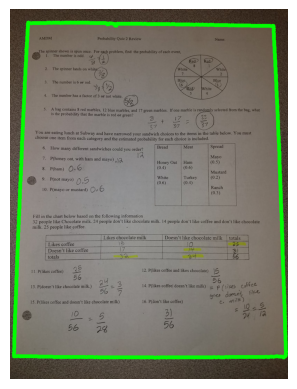

In [94]:
img = cv2.imread("homework.png")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 21, 6)
dilated = cv2.dilate(thresh, np.ones((3, 3)))
contours, _ = cv2.findContours(cv2.bitwise_not(dilated, np.full_like(img, 255)), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
paper = max(contours, key=lambda cnt: cv2.contourArea(cnt))
imshow(cv2.drawContours(img.copy(), [paper], 0, (0, 255, 0), 10))

Get the four points around the paper regardless of perspective

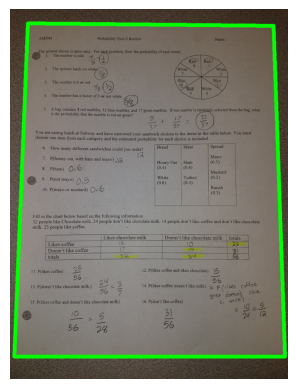

In [96]:
min_area_rect = cv2.boxPoints(cv2.minAreaRect(paper))
points = [None] * 4
dists = [100_000] * 4
for point in paper.reshape(-1, 2):
    for i, (rect_point, stored, d) in enumerate(zip(min_area_rect, points, dists)):
        if (new_dist:=math.dist(point, rect_point)) < d: 
            dists[i] = new_dist
            points[i] = [*point]
final_paper = np.array(points)
imshow(cv2.drawContours(img.copy(), [final_paper], 0, (0, 255, 0), 10))

Perform four-point transform to isolate paper, making OCR easier

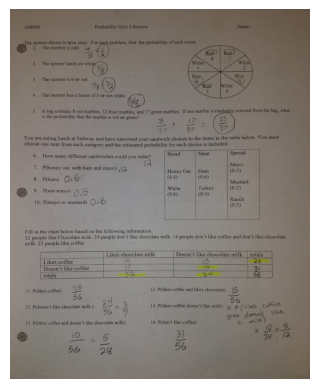

In [128]:
points = sorted(points, key=lambda x: x[1])
tl, tr = sorted(points[0:2], key=lambda x: x[0])
bl, br = sorted(points[2:4], key=lambda x: x[0])
max_height = int(max(math.dist(bl, tl), math.dist(br, tr)))
max_width = int(max(math.dist(bl, br), math.dist(tl, tr)))
dst = np.array([
        [0, 0],
		[max_width - 1, 0],
		[max_width - 1, max_height - 1],
		[0, max_height - 1]
    ], dtype='float32')
M = cv2.getPerspectiveTransform(np.array([tl, tr, br, bl], dtype='float32'), dst)
warped = cv2.warpPerspective(img, M, (max_width, max_height))
imshow(warped)

In [131]:
OCR = PaddleOCR(use_angle_cls=True, lang='en', show_log=False, rotation=True)
text = OCR.ocr(warped)

download https://paddleocr.bj.bcebos.com/PP-OCRv4/english/en_PP-OCRv4_rec_infer.tar to /Users/vs/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer/en_PP-OCRv4_rec_infer.tar


100%|██████████| 10.2M/10.2M [00:09<00:00, 1.09MiB/s]


In [132]:
text

[[[[[36.0, 39.0], [79.0, 39.0], [79.0, 54.0], [36.0, 54.0]],
   ('AMDM', 0.9948999285697937)],
  [[[220.0, 39.0], [358.0, 39.0], [358.0, 53.0], [220.0, 53.0]],
   ('Probability Quiz2 Review', 0.9676139950752258)],
  [[[588.0, 37.0], [624.0, 39.0], [623.0, 53.0], [587.0, 51.0]],
   ('Name:', 0.9522857666015625)],
  [[[39.0, 80.0], [483.0, 80.0], [483.0, 94.0], [39.0, 94.0]],
   ('The spinner shown is spun once. For cach problem, find the probability of each event',
    0.9442539215087891)],
  [[[58.0, 94.0], [187.0, 94.0], [187.0, 107.0], [58.0, 107.0]],
   ('1.The number is odd.', 0.9741314649581909)],
  [[[506.0, 106.0], [540.0, 106.0], [540.0, 123.0], [506.0, 123.0]],
   ('Red', 0.991497278213501)],
  [[[554.0, 104.0], [585.0, 104.0], [585.0, 120.0], [554.0, 120.0]],
   ('Red', 0.9819514155387878)],
  [[[470.0, 132.0], [508.0, 132.0], [508.0, 147.0], [470.0, 147.0]],
   ('White', 0.9974824786186218)],
  [[[57.0, 134.0], [213.0, 136.0], [213.0, 150.0], [57.0, 148.0]],
   ('2.The spinn